In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.pardir))
sys.path.append(os.path.abspath(os.pardir)+"/src")

import random

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection as ms
from mongoengine import connect, disconnect_all
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             log_loss, plot_roc_curve)
import pandas as pd

from src.utils import mongo_to_df, classification_report_as_df

np.random.seed(21)
random.seed(21)

### Preparando dados

In [145]:
connect("tcc")
df = mongo_to_df()
disconnect_all()

In [146]:
df.head()

_id  answer_1  answer_2  answer_3  \
0  FAKE_answer-63995b725eb64a1b8abc812545ce0699      True     False     False   
1  FAKE_answer-555e5216ed8041d984ee09e262a8c965      True     False     False   
2  FAKE_answer-961fe085badd40ff96dbc008b7d80e6e      True     False     False   
3  FAKE_answer-19f8707276144cb68ab412a40fe81089     False      True     False   
4  FAKE_answer-d28f0212aaf74499921c7dfae9700b74      True     False      True   

   answer_4  answer_5  answer_6  answer_7  answer_8  answer_9  answer_10  \
0     False     False      True     False      True      True       True   
1     False      True     False     False      True     False       True   
2     False      True      True      True     False      True       True   
3      True     False     False     False     False     False      False   
4     False      True      True     False      True      True       True   

   answer_11  evaded                                     user_id  
0       True   False  FAKE_user-5421f7366993456aacc69277d3b812ef  
1       True    True  FAKE_user-92d1cfb93ef1496a9deee5d21b2b42c2  
2       True    True  FAKE_user-aefb62d02fd84f26bbed9f5b6f7a9d87  
3      False   False  FAKE_user-10eb4a031d6746398e481f4ffe7cd696  
4      False   False  FAKE_user-b22267d5da2c46a99255db4f1fad7f5f

In [147]:
df = df.drop(columns=["_id", "user_id"])

In [67]:
# df = df.astype(int)

In [68]:
df.head()

answer_1  answer_2  answer_3  answer_4  answer_5  answer_6  answer_7  \
0      True     False     False     False     False      True     False   
1      True     False     False     False      True     False     False   
2      True     False     False     False      True      True      True   
3     False      True     False      True     False     False     False   
4      True     False      True     False      True      True     False   

   answer_8  answer_9  answer_10  answer_11  evaded  
0      True      True       True       True   False  
1      True     False       True       True    True  
2     False      True       True       True    True  
3     False     False      False      False   False  
4      True      True       True      False   False

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   answer_1   100 non-null    bool 
 1   answer_2   100 non-null    bool 
 2   answer_3   100 non-null    bool 
 3   answer_4   100 non-null    bool 
 4   answer_5   100 non-null    bool 
 5   answer_6   100 non-null    bool 
 6   answer_7   100 non-null    bool 
 7   answer_8   100 non-null    bool 
 8   answer_9   100 non-null    bool 
 9   answer_10  100 non-null    bool 
 10  answer_11  100 non-null    bool 
 11  evaded     100 non-null    bool 
dtypes: bool(12)
memory usage: 1.3 KB


In [11]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

### Separação dos dados

In [9]:
# X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

In [10]:
len(X_train)

80

# Métricas de avaliação

## Matriz de confusão

* Positivo Verdadeiro (True Positive – TP) que significa que a classe prevista e observada originalmente fazem parte da classe positiva;

* Falso Positivo (False Positive – FP) que significa que a classe predita retornou positivo mas a original observada era negativa;

* Negativo Verdadeiro (True Negative – TN) os valores preditos e observados fazem parte da categoria negativa;

* Falso Negativo (False Negative – FN) representa que o valor predito resultou na classe negativa mas o original observado era da classe positivo.

<img src="../img/matriz_confusao.png" width="400"/>

## Métricas de avaliação da Matriz de Confusão

* Acurácia (Acurary): Quantidade classificada como Positivos e Negativos corretamente, e pode ser formalizada em (TP + TN) / (TP + TN + FP + TN)

* Precisão (Precision): Quantidade Positiva classificada corretamente. E é calculada por TP / (TP + FP)

* Revocação (Recall): Taxa de valores classificada como Positivo, comparada com quantos deveriam ser. E pode ser calculada como TP / (TP + FN)

* Pontuação F1 (F1 SCORE): É calculado como a média harmônica entre Precisão e Recall, sendo sua formulação matemática representada por (2* TP) / (2* TP + FP + FN)


# Regressão Logística

In [14]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6


In [15]:
logistic_roc = plot_roc_curve(classifier, X_test, y_test)

In [16]:
print(confusion_matrix(y_test, y_pred))

[[4 3]
 [5 8]]


In [17]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False          0.444444  0.571429  0.500000      7.0
True           0.727273  0.615385  0.666667     13.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.585859  0.593407  0.583333     20.0
weighted avg   0.628283  0.600000  0.608333     20.0

# Árvore de decisão

In [20]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier()
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8


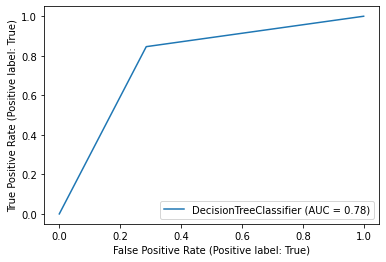

In [21]:
decision_tree_roc = plot_roc_curve(classifier, X_test, y_test)

In [22]:
print(confusion_matrix(y_test, y_pred))

[[ 5  2]
 [ 2 11]]


In [23]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False          0.714286  0.714286  0.714286      7.0
True           0.846154  0.846154  0.846154     13.0
accuracy       0.800000  0.800000  0.800000      0.8
macro avg      0.780220  0.780220  0.780220     20.0
weighted avg   0.800000  0.800000  0.800000     20.0

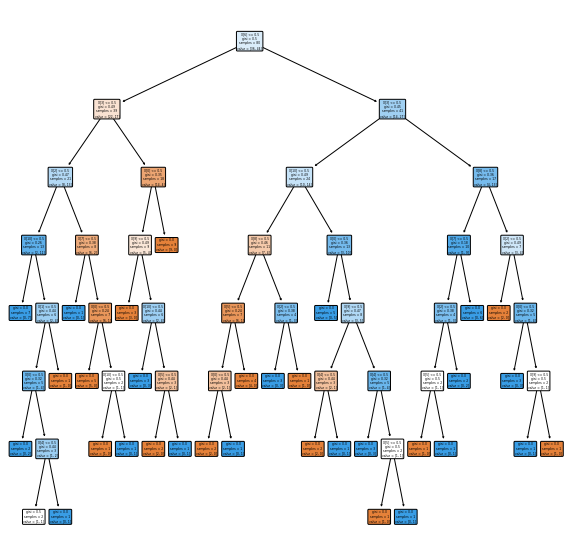

In [24]:
plt.figure(figsize=(10,10))
tree.plot_tree(classifier,filled=True,rounded=True, proportion=False, precision = 2)  
plt.savefig('../img/decision_tree.pdf',format='pdf',bbox_inches = "tight")

# Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
estimators = 5
classifier = RandomForestClassifier(n_estimators=estimators)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.6


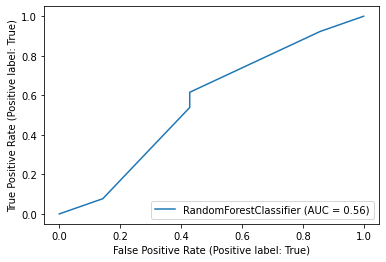

In [55]:
random_forest_roc = plot_roc_curve(classifier, X_test, y_test)

In [56]:
print(confusion_matrix(y_test, y_pred))

[[4 3]
 [5 8]]


In [57]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False          0.444444  0.571429  0.500000      7.0
True           0.727273  0.615385  0.666667     13.0
accuracy       0.600000  0.600000  0.600000      0.6
macro avg      0.585859  0.593407  0.583333     20.0
weighted avg   0.628283  0.600000  0.608333     20.0

In [58]:
from sklearn.tree import export_graphviz
# Export as dot file
# export_graphviz(estimators, out_file='tree.dot', 
#                 feature_names = iris.feature_names,
#                 class_names = iris.target_names,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# uma arvore da floresta
estimator = classifier.estimators_[estimators-1]

export_graphviz(estimator, out_file='../img/random_forest.dot',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', '../img/random_forest.dot', '-o', '../img/random_forest.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = '../img/random_forest.png')

# Support Vector Machine

In [61]:
from sklearn.svm import SVC
classifier = SVC(random_state=42)
classifier = classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.65


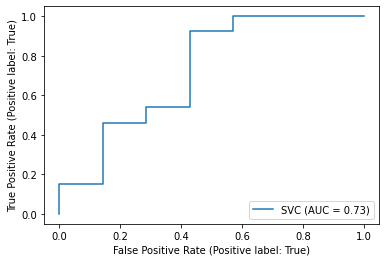

In [62]:
svm_roc = plot_roc_curve(classifier, X_test, y_test)

In [63]:
print(confusion_matrix(y_test, y_pred))

[[4 3]
 [4 9]]


In [64]:
classification_report_as_df(y_test, y_pred)

precision    recall  f1-score  support
False            0.5000  0.571429  0.533333     7.00
True             0.7500  0.692308  0.720000    13.00
accuracy         0.6500  0.650000  0.650000     0.65
macro avg        0.6250  0.631868  0.626667    20.00
weighted avg     0.6625  0.650000  0.654667    20.00

# Plotando ROC dos modelos

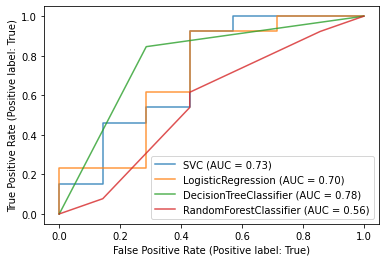

In [65]:
ax = plt.gca()
svm_roc.plot(ax=ax, alpha=0.8)
logistic_roc.plot(ax=ax, alpha=0.8)
decision_tree_roc.plot(ax=ax, alpha=0.8)
random_forest_roc.plot(ax=ax, alpha=0.8)

# Data Augmentation

In [16]:
df

answer_1  answer_2  answer_3  answer_4  answer_5  answer_6  answer_7  \
0       True     False     False     False     False      True     False   
1       True     False     False     False      True     False     False   
2       True     False     False     False      True      True      True   
3      False      True     False      True     False     False     False   
4       True     False      True     False      True      True     False   
..       ...       ...       ...       ...       ...       ...       ...   
95     False     False     False      True     False      True      True   
96      True      True      True      True      True      True     False   
97     False      True      True     False     False      True     False   
98     False      True      True     False      True      True     False   
99      True      True      True      True     False     False     False   

    answer_8  answer_9  answer_10  answer_11  evaded  
0       True      True       True       True   False  
1       True     False       True       True    True  
2      False      True       True       True    True  
3      False     False      False      False   False  
4       True      True       True      False   False  
..       ...       ...        ...        ...     ...  
95     False     False       True      False    True  
96     False      True       True      False   False  
97      True      True      False       True   False  
98      True      True      False       True   False  
99      True     False       True       True   False  

[100 rows x 12 columns]

In [94]:
len_of_answers = len(df.columns[:-1])

In [175]:
len(df)

100

In [197]:
def data_augmentation(df, len_of_answers):
    evaded = df['evaded'].copy()
    df = df[df.columns.drop('evaded')]
    temp = []
    for i in range(len_of_answers+1, (len_of_answers*2)+1):
        for _ in range(len(df)):
            temp.append(random.choice([True, False]))
        df['answer_'+str(i)] = temp.copy()
        temp.clear()
    df['evaded'] = evaded
    return df

In [198]:
df = data_augmentation(df, len_of_answers)

<ipython-input-197-37d2a0ac52d5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['answer_'+str(i)] = temp.copy()


In [199]:
df.columns

Index(['answer_1', 'answer_2', 'answer_3', 'answer_4', 'answer_5', 'answer_6',
       'answer_7', 'answer_8', 'answer_9', 'answer_10', 'answer_11',
       'answer_12', 'answer_13', 'answer_14', 'answer_15', 'answer_16',
       'answer_17', 'answer_18', 'answer_19', 'answer_20', 'answer_21',
       'answer_22', 'evaded'],
      dtype='object')

In [200]:
df

answer_1  answer_2  answer_3  answer_4  answer_5  answer_6  answer_7  \
0       True     False     False     False     False      True     False   
1       True     False     False     False      True     False     False   
2       True     False     False     False      True      True      True   
3      False      True     False      True     False     False     False   
4       True     False      True     False      True      True     False   
..       ...       ...       ...       ...       ...       ...       ...   
95     False     False     False      True     False      True      True   
96      True      True      True      True      True      True     False   
97     False      True      True     False     False      True     False   
98     False      True      True     False      True      True     False   
99      True      True      True      True     False     False     False   

    answer_8  answer_9  answer_10  ...  answer_14  answer_15  answer_16  \
0       True      True       True  ...      False       True       True   
1       True     False       True  ...      False      False       True   
2      False      True       True  ...      False       True       True   
3      False     False      False  ...      False      False       True   
4       True      True       True  ...      False      False       True   
..       ...       ...        ...  ...        ...        ...        ...   
95     False     False       True  ...      False      False       True   
96     False      True       True  ...      False       True       True   
97      True      True      False  ...       True      False       True   
98      True      True      False  ...      False       True       True   
99      True     False       True  ...       True      False       True   

    answer_17  answer_18  answer_19  answer_20  answer_21  answer_22  evaded  
0        True      False       True       True      False      False   False  
1        True       True       True      False       True       True    True  
2        True       True       True      False       True      False    True  
3        True      False       True       True       True      False   False  
4        True      False       True      False       True       True   False  
..        ...        ...        ...        ...        ...        ...     ...  
95      False      False      False       True       True       True    True  
96       True       True      False       True      False      False   False  
97       True      False       True       True       True       True   False  
98       True       True       True       True      False       True   False  
99       True      False       True      False       True      False   False  

[100 rows x 23 columns]